In [2]:
import datetime
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from datasets import get_datasets, get_shiller
import matplotlib.pyplot as plt
import random

time_horizon = 40

data = get_datasets()
data['returns_with_dividends'] = data['simple_return'] + data['dividend_return']

[*********************100%***********************]  1 of 1 completed


In [140]:
import numpy as np

def calculate_portfolio_return(returns, weights):
    return np.dot(returns, weights)

def calculate_utility(return_value, zeta):
    if zeta == 1:
        return np.log(return_value)
    else:
        return (return_value**(1 - zeta)) / (1 - zeta)

def calculate_portfolio_utility(returns, weights, zeta):
    portfolio_return = calculate_portfolio_return(returns, weights)
    return calculate_utility(portfolio_return, zeta)

def optimize_portfolio(returns, risk_free_returns, zeta):
    num_assets = returns.shape[1]  # Number of assets
    num_observations = returns.shape[0]  # Number of observations

    def objective_function(weights):
        portfolio_return = calculate_portfolio_return(returns, weights)
        excess_return = portfolio_return - risk_free_returns
        utility = calculate_utility(excess_return, zeta)
        return -np.mean(utility)  # Return the negative mean utility as a scalar

    # Constraints: weights sum up to 1
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

    # Bounds: each weight is between 0 and 1
    bounds = [(0, 1) for _ in range(num_assets)]

    # Initial guess for weights
    initial_weights = np.ones(num_assets) / num_assets

    # Solve the optimization problem
    from scipy.optimize import minimize
    result = minimize(objective_function, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result.x

# Example usage
risk_free_returns = data['returns_rf'].values
returns = data['returns_with_dividends'].values
zeta = 3  # Risk aversion parameter

time_periods = {
    '1-month': 1,
    '6-month': 6,
    '12-month': 12,
    '2-year': 24,
    '5-year': 60
}

for period, num_months in time_periods.items():
    start_idx = 0  # Adjust the start index based on the desired time period
    end_idx = start_idx + num_months  # Adjust the end index based on the desired time period

    risk_free_returns_period = risk_free_returns[start_idx:end_idx]
    returns_period = returns[start_idx:end_idx]

    # Reshape the returns array if it has a single column
    if returns_period.ndim == 1:
        returns_period = returns_period.reshape(-1, 1)

    optimized_weights = optimize_portfolio(returns_period, risk_free_returns_period, zeta)
    print(f"Optimized weights for {period}: {optimized_weights}")


Optimized weights for 1-month: [1.]
Optimized weights for 6-month: [1.]
Optimized weights for 12-month: [1.]
Optimized weights for 2-year: [1.]
Optimized weights for 5-year: [1.]


In [141]:
def logarithmic_utility(returns):
    return np.log(returns)

def isoelastic_utility(returns, rho=0.7):
    return (returns ** (1 - 0.7)) / (1 - 0.7)

def power_utility(returns, alpha=0.5):
    return returns ** alpha

utility_functions = {
    'logarithmic': logarithmic_utility,
    'isoelastic': isoelastic_utility,
    'power': power_utility,
}

In [142]:
import numpy as np
import pandas as pd
from scipy.stats import norm

# Define the risk aversion coefficient
rho = 0.5

# Define utility function
def isoelastic_utility(wealth, rho=0.5):
    return (wealth ** (1 - rho)) / (1 - rho)

# Inverse of the isoelastic utility function
def isoelastic_utility_inv(u, rho):
    return ((1 - rho) * u) ** (1 / (1 - rho))

# Initialize the allocation array for each horizon
allocation_max_utility_each_horizon = np.zeros((len(horizons), 2))  # we store the risky and risk-free allocations for each horizon

# Loop through each investment horizon
for h_idx, horizon in enumerate(horizons):

    # Initialize the variable to store the max utility for the current horizon
    max_utility_current_horizon = -np.inf
    optimal_allocation_current_horizon = [0, 0]

    # Loop over potential allocations to the risky asset (from 0.05 to 1, with a step of 0.05)
    for risky_allocation in np.arange(0, 1.05, 0.05):
        # The allocation to the risk-free asset is the complement
        risk_free_allocation = 1 - risky_allocation

        # Initialize the variable to store the sum of utilities over the portfolios for the current horizon
        sum_utilities_current_horizon = 0

        # Calculate the number of months in the specified time horizon
        months_in_horizon = horizon * 12

        # Loop through each portfolio and calculate the cumulative returns
        for i in range(n_portfolios):
            if(i) == 100:
                break
            start_idx = i
            end_idx = start_idx + months_in_horizon

            risk_free_returns = data.loc[start_idx:end_idx-1, 'returns_rf'].values
            returns = data.loc[start_idx:end_idx-1, 'returns_with_dividends'].values

            # Calculate cumulative returns for the current portfolio
            cum_risk_free_returns_portfolios = np.prod(1 + risk_free_returns) - 1+1
            cum_returns_portfolios = np.prod(1 + returns) - 1+1

            # Calculate the portfolio return
            portfolio_return = risky_allocation * (np.prod(1 + returns) - 1) + risk_free_allocation * (np.prod(1 + risk_free_returns) - 1)
        
            # Generate a distribution of possible outcomes for the portfolio return
            sigma = np.std(portfolio_return)
      

            probabilities = norm.pdf(portfolio_return, portfolio_return, sigma)
            probabilities /= probabilities.sum()  # normalize to sum to 1

            # Calculate expected utility of the portfolio return
            expected_utility = (isoelastic_utility(portfolio_return, rho) * probabilities).sum()

            # Calculate the certainty equivalent of the portfolio return
            certainty_equivalent = isoelastic_utility_inv(expected_utility, rho)

            # Add the certainty equivalent to the sum of utilities
            sum_utilities_current_horizon += certainty_equivalent

        # Calculate the average utility over the portfolios for the current horizon
        average_utility_current_horizon = sum_utilities_current_horizon / n_portfolios

        # If the average utility is higher than the max utility found so far, update the max utility and the optimal allocations
        if average_utility_current_horizon > max_utility_current_horizon:
            max_utility_current_horizon = average_utility_current_horizon
            optimal_allocation_current_horizon = [risky_allocation, risk_free_allocation]

    # Store the optimal allocation for the current horizon
    allocation_max_utility_each_horizon[h_idx] = optimal_allocation_current_horizon

print("Optimal allocations for each horizon:", allocation_max_utility_each_horizon)


Optimal allocations for each horizon: [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


/var/folders/p_/sj7lt16104lck02ntqq_6pjm0000gn/T/ipykernel_92296/3893293859.py:10: RuntimeWarning: invalid value encountered in scalar power
  return (wealth ** (1 - rho)) / (1 - rho)


In [143]:
# Initialize the allocation array for each horizon
allocation_max_utility_each_horizon = np.zeros((len(horizons), 2))  # we store the risky and risk-free allocations for each horizon

# Loop through each investment horizon
for h_idx, horizon in enumerate(horizons):
    # Initialize the variable to store the max utility for the current horizon
    max_utility_current_horizon = -np.inf
    optimal_allocation_current_horizon = [0, 0]

    # Loop over potential allocations to the risky asset (from 0 to 1, with a step of 0.01)
    for risky_allocation in np.arange(0, 1.01, 0.01):
        # The allocation to the risk-free asset is the complement
        risk_free_allocation = 1 - risky_allocation

        # Initialize the variable to store the sum of utilities over the portfolios for the current horizon
        sum_utilities_current_horizon = 0

        # Calculate the number of months in the specified time horizon
        months_in_horizon = horizon * 12

        # Loop through each portfolio and calculate the cumulative returns
        for i in range(n_portfolios):
            start_idx = i
            end_idx = start_idx + months_in_horizon

            risk_free_returns = data.loc[start_idx:end_idx-1, 'returns_rf'].values
            returns = data.loc[start_idx:end_idx-1, 'returns_with_dividends'].values

            # Calculate cumulative returns for the current portfolio
            cum_risk_free_returns_portfolios = np.prod(1 + risk_free_returns) - 1
            cum_returns_portfolios = np.prod(1 + returns) - 1

            # Calculate the portfolio return
            portfolio_return = risky_allocation * cum_returns_portfolios + risk_free_allocation * cum_risk_free_returns_portfolios

            # Calculate the utility of the portfolio return
            utility = isoelastic_utility(portfolio_return, rho)

            # Add the utility to the sum of utilities
            sum_utilities_current_horizon += utility

        # Calculate the average utility over the horizon
        average_utility_current_horizon = sum_utilities_current_horizon / n_portfolios

        # If the average utility is higher than the max utility found so far, update the max utility and the optimal allocations
        if average_utility_current_horizon > max_utility_current_horizon:
            max_utility_current_horizon = average_utility_current_horizon
            optimal_allocation_current_horizon = [risky_allocation, risk_free_allocation]

    # Store the optimal allocation for the current horizon
    allocation_max_utility_each_horizon[h_idx] = optimal_allocation_current_horizon


/var/folders/p_/sj7lt16104lck02ntqq_6pjm0000gn/T/ipykernel_92296/3893293859.py:10: RuntimeWarning: invalid value encountered in scalar power
  return (wealth ** (1 - rho)) / (1 - rho)


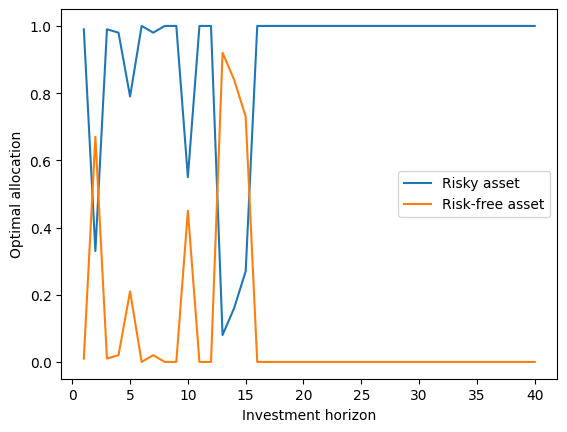

In [ ]:
import matplotlib.pyplot as plt

# Plot the optimal allocations as a function of investment horizon
plt.plot(horizons, allocation_max_utility_each_horizon[:, 0], label='Risky asset')
plt.plot(horizons, allocation_max_utility_each_horizon[:, 1], label='Risk-free asset')

plt.xlabel('Investment horizon')
plt.ylabel('Optimal allocation')
plt.legend()
plt.show()